# Testing for FCC Cats and Dogs Project

In [1]:
!ls cats_and_dogs

test  train  validation


In [72]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import numpy as np

In [1]:
def view_random_image(target_dir, target_class):
    # Setup the target directory
    target_folder = target_dir + '/' + target_class
    
    # get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)
    print(random_image)
    
    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + '/'  + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')
    
    # Show the shape of the image
    print(f'Image shape: {img.shape}')
    
    return img

['dog.515.jpg']
Image shape: (375, 499, 3)


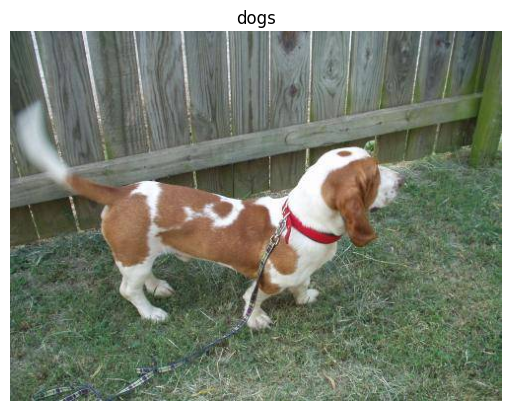

In [3]:
# View a random image from the training data set
img = view_random_image('cats_and_dogs/train', 'dogs')

In [76]:
# Create train and test data generators to rescale the data

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

train_datagen = ImageDataGenerator(rescale=1/255.)
val_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [78]:
# Set global seed for reproducability
tf.random.set_seed(42)

In [64]:
PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirectories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 32
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

In [65]:
# Load in our image data and turn them into batches
train_data = train_datagen.flow_from_directory(directory=train_dir, 
                                               target_size=(150,150),
                                              class_mode='binary',
                                              batch_size=32)
                                    
val_data = val_datagen.flow_from_directory(directory=val_dir, 
                                               target_size=(150,150),
                                              class_mode='binary',
                                              batch_size=32)

test_data = test_datagen.flow_from_directory(directory='cats_and_dogs',
                                                    target_size=(150,150),
                                                    batch_size=50,
                                                    classes=['test'],                                             
                                                    class_mode=None,
                                                    shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


In [69]:
# Check classes found
print(train_data.class_indices)
print(val_data.class_indices)
print(test_data.class_indices)

{'cats': 0, 'dogs': 1}
{'cats': 0, 'dogs': 1}
{'test': 0}


## Evaluation Functions

In [27]:
# plot the validation and training curves separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss'])) # how many epochs we ran for
    
    # plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('loss')
    plt.xlabel('epochs')
    plt.legend()
    
    # plot accuracy
    plt.figure() # create a 2nd figure
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('accuracy')
    plt.xlabel('epochs')
    plt.legend()

In [70]:
def test_score(model, test_data):
    probabilities = np.ndarray.flatten(model.predict(test_data))
        
    answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
                1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
                1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
                1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
                0, 0, 0, 0, 0, 0]

    correct = 0

    for probability, answer in zip(probabilities, answers):
      if round(probability) == answer:
        correct +=1

    percentage_identified = (correct / len(answers)) * 100

    passed_challenge = percentage_identified >= 63

    print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

    if passed_challenge:
      print("You passed the challenge!")
    else:
      print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

## Model 1 - Baseline

In [86]:
# Create the baseline model
model_1 = Sequential([
    Conv2D(10, kernel_size=3, activation='relu', input_shape=(150,150,3)),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [87]:
model_1.compile(loss='binary_crossentropy', 
                optimizer=Adam(), 
                metrics=['accuracy'])

In [88]:
model_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 148, 148, 10)      280       
                                                                 
 conv2d_22 (Conv2D)          (None, 146, 146, 10)      910       
                                                                 
 conv2d_23 (Conv2D)          (None, 144, 144, 10)      910       
                                                                 
 flatten_7 (Flatten)         (None, 207360)            0         
                                                                 
 dense_7 (Dense)             (None, 1)                 207361    
                                                                 
Total params: 209,461
Trainable params: 209,461
Non-trainable params: 0
_________________________________________________________________


In [89]:
len(train_data), train_data.n / 32

(63, 62.5)

In [90]:
history_1 = model_1.fit(train_data,
                       epochs=5,
                       steps_per_epoch=len(train_data),
                       validation_data=val_data,
                       validation_steps=len(val_data))

Epoch 1/5
63/63 [==============================] - 5s 76ms/step - loss: 0.9145 - accuracy: 0.4985 - val_loss: 0.6752 - val_accuracy: 0.5000
Epoch 2/5
63/63 [==============================] - 6s 103ms/step - loss: 0.6728 - accuracy: 0.5110 - val_loss: 0.6700 - val_accuracy: 0.5300
Epoch 3/5
63/63 [==============================] - 7s 103ms/step - loss: 0.6447 - accuracy: 0.6040 - val_loss: 0.6768 - val_accuracy: 0.6210
Epoch 4/5
63/63 [==============================] - 7s 104ms/step - loss: 0.5741 - accuracy: 0.7175 - val_loss: 0.6716 - val_accuracy: 0.5960
Epoch 5/5
63/63 [==============================] - 7s 103ms/step - loss: 0.4372 - accuracy: 0.8105 - val_loss: 0.7200 - val_accuracy: 0.5990


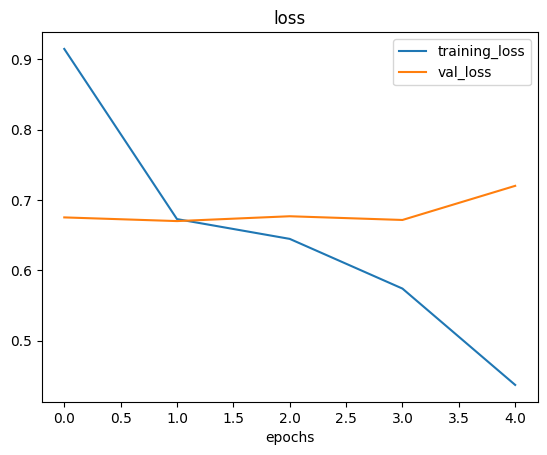

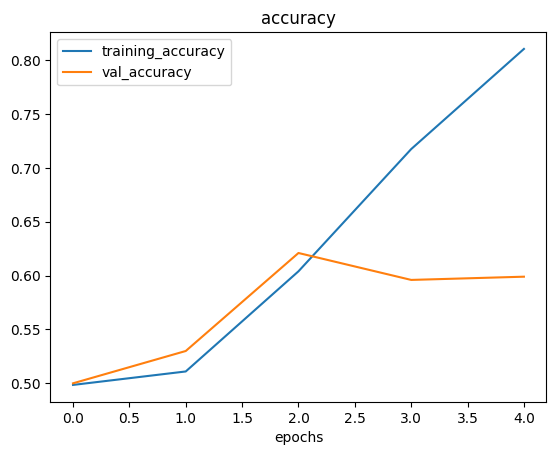

In [91]:
# Check out the loss and accuracy of model_1
plot_loss_curves(history_1)

In [92]:
model_1.evaluate(val_data)

32/32 [==============================] - 1s 29ms/step - loss: 0.7200 - accuracy: 0.5990


[0.7200196981430054, 0.5989999771118164]

In [93]:
test_score(model_1, test_data)

1/1 [==============================] - 0s 110ms/step
Your model correctly identified 56.0% of the images of cats and dogs.
You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!


## Model 2 - Add Max Pooling

In [94]:
model_2 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(150, 150, 3)),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [95]:
model_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 148, 148, 10)      280       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 72, 72, 10)        910       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 34, 34, 10)        910       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 17, 17, 10)      

In [96]:
model_2.compile(loss='binary_crossentropy',
               optimizer=Adam(),
               metrics=['accuracy'])

In [97]:
history_2 = model_2.fit(train_data,
                       epochs=5,
                       steps_per_epoch=len(train_data),
                       validation_data=val_data,
                       validation_steps=len(val_data))

Epoch 1/5
63/63 [==============================] - 3s 46ms/step - loss: 0.6841 - accuracy: 0.5270 - val_loss: 0.6557 - val_accuracy: 0.6300
Epoch 2/5
63/63 [==============================] - 3s 45ms/step - loss: 0.6626 - accuracy: 0.5890 - val_loss: 0.6407 - val_accuracy: 0.6160
Epoch 3/5
63/63 [==============================] - 3s 43ms/step - loss: 0.6402 - accuracy: 0.6225 - val_loss: 0.6359 - val_accuracy: 0.6450
Epoch 4/5
63/63 [==============================] - 3s 44ms/step - loss: 0.6194 - accuracy: 0.6520 - val_loss: 0.6128 - val_accuracy: 0.6610
Epoch 5/5
63/63 [==============================] - 3s 45ms/step - loss: 0.5806 - accuracy: 0.6855 - val_loss: 0.5859 - val_accuracy: 0.6870


In [99]:
model_2.evaluate(val_data)

32/32 [==============================] - 1s 25ms/step - loss: 0.5859 - accuracy: 0.6870


[0.585859477519989, 0.6869999766349792]

In [100]:
test_score(model_2, test_data)

1/1 [==============================] - 0s 91ms/step
Your model correctly identified 72.0% of the images of cats and dogs.
You passed the challenge!


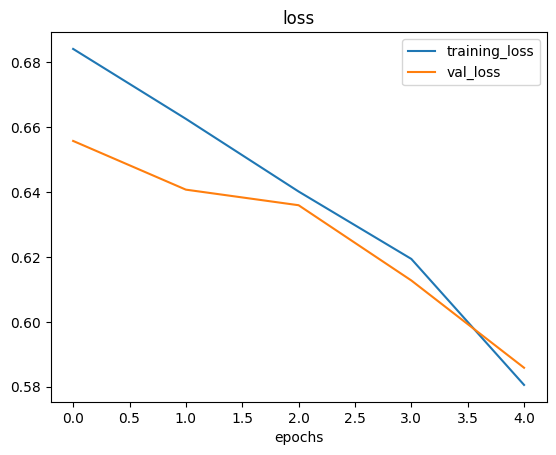

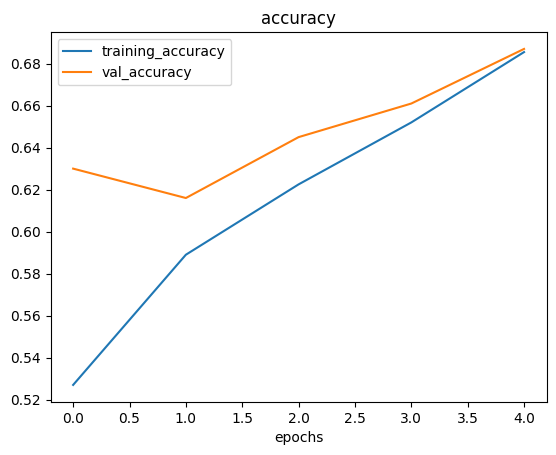

In [101]:
plot_loss_curves(history_2)